In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/sample_submission.csv
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/test.csv
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/LICENSE
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/README.md
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/meta/esc50.csv
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/meta/esc50-human.xlsx
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/audio/5-257349-A-15.wav
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/audio/5-195557-A-19.wav
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/audio/2-122820-B-36.wav
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/audio/1-115920-A-22.wav
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/audio/1-172649-C-40.wav
/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/ESC-50-master/audio/

In [86]:
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report


DATA_ROOT = "/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup"
STEMS_PATH = os.path.join(DATA_ROOT, 'genres_stems')

GENRES = ["blues", "classical", "country", "disco",
          "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

# Actual stem filenames
STEMS = ["drums.wav", "vocals.wav", "bass.wav", "other.wav"]

# Keys we remove the extension
STEM_KEYS = ["drums", "vocals", "bass", "other"]


print("Genres:", GENRES)
print("Stem keys:", STEM_KEYS)

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Stem keys: ['drums', 'vocals', 'bass', 'other']


In [87]:
# Question 1

jazz_path = "/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/genres_stems/jazz"
durations = []

for song_folder in os.listdir(jazz_path):
    song_path = os.path.join(jazz_path, song_folder)
    
    # Skip if not a directory
    if not os.path.isdir(song_path):
        continue
    
    # Each song has 4 stems
    for stem_file in os.listdir(song_path):
        if stem_file.endswith(".wav"):
            
            file_path = os.path.join(song_path, stem_file)
            
            duration = librosa.get_duration(path=file_path)
            durations.append(duration)

mean_duration = round(np.mean(durations), 3)

print("Total stems:", len(durations))
print("Mean duration (seconds):", mean_duration)

Total stems: 400
Mean duration (seconds): 30.033


In [88]:
# Question 2

unique_sample_rates = set()

for root, dirs, files in os.walk(DATA_ROOT):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            
            try:
                sr = librosa.get_samplerate(file_path)
                unique_sample_rates.add(sr)
            except Exception as e:
                print("Error reading:", file_path)
                
unique_sample_rates = sorted(list(unique_sample_rates))
print("unique sample rates present in the entire dataset are : " , unique_sample_rates)         

unique sample rates present in the entire dataset are :  [22050, 44100]


In [89]:
# Question 3

zero_byte_count = 0
total_wav_files = 0

for root, dirs, files in os.walk(STEMS_PATH):
    for file in files:
        if file.endswith(".wav"):
            total_wav_files += 1
            
            file_path = os.path.join(root, file)
            
            if os.path.getsize(file_path) == 0:
                zero_byte_count += 1

print("Total song WAV files:", total_wav_files)
print("Zero-byte files:", zero_byte_count)

Total song WAV files: 4000
Zero-byte files: 0


In [90]:
# Question 4

vocal_peaks_db = []

for root, dirs, files in os.walk(STEMS_PATH):
    for file in files:
        if file == "vocals.wav":
            file_path = os.path.join(root, file)
            
            y, sr = librosa.load(file_path, sr=None)
            
            peak = np.max(np.abs(y))
            
            if peak > 0:
                peak_db = 20 * np.log10(peak)
                vocal_peaks_db.append(peak_db)

average_peak_db = np.mean(vocal_peaks_db)

print("Average Peak Amplitude (dB):", average_peak_db)

Average Peak Amplitude (dB): -12.494921


In [91]:
# Question 5

blue_path = "/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/genres_stems/blues"

centroid_values = []

for song in os.listdir(blue_path):
    song_path = os.path.join(blue_path, song)
    
    if not os.path.isdir(song_path):
        continue
    
    for stem in os.listdir(song_path):
        if stem.endswith(".wav"):
            file_path = os.path.join(song_path, stem)
            
            # Load and resample to 22050 (consistent pipeline)
            y, sr = librosa.load(file_path, sr=22050)
            
            # Compute spectral centroid
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            
            # Take mean over time frames
            centroid_mean = np.mean(centroid)
            
            centroid_values.append(centroid_mean)

# Final mean across all blues stems
final_mean_centroid = np.mean(centroid_values)

print("Total stems processed:", len(centroid_values))
print("Mean spectral centroid (Hz):", round(final_mean_centroid , 3))

Total stems processed: 400
Mean spectral centroid (Hz): 2067.556


In [92]:
# Question 6

genre_centroids = {}

for genre in GENRES:
    values = []
    genre_folder = os.path.join(STEMS_PATH, genre)

    for song in os.listdir(genre_folder):
        song_folder = os.path.join(genre_folder, song)

        if not os.path.isdir(song_folder):
            continue

        file1 = os.path.join(song_folder, "other.wav")
        file2 = os.path.join(song_folder, "others.wav")

        if os.path.exists(file1):
            path = file1
        elif os.path.exists(file2):
            path = file2
        else:
            continue

        y, sr = librosa.load(path, sr=22050)

        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        mean_value = np.mean(centroid)

        values.append(mean_value)

    if len(values) > 0:
        genre_centroids[genre] = np.mean(values)

highest_genre = max(genre_centroids, key=genre_centroids.get)
print("Mean Spectral Centroid per Genre:")
for g, val in genre_centroids.items():
    print(f"{g}: {val}")
print("Highest spectral centroid genre:", highest_genre)

Mean Spectral Centroid per Genre:
blues: 1597.8387497380847
classical: 1357.8935316163452
country: 1363.486739099068
disco: 1798.606654557341
hiphop: 2429.2962754907903
jazz: 1554.8343991374256
metal: 2418.801885494158
pop: 1517.4679898262727
reggae: 1761.585430812623
rock: 1547.635900011739
Highest spectral centroid genre: hiphop


In [93]:
# Question 7

silent_count = 0
total_files = 0

for root, dirs, files in os.walk(STEMS_PATH):
    for file in files:
        if file.endswith(".wav"):
            total_files += 1
            
            file_path = os.path.join(root, file)
            
            # Load only first 0.5 seconds
            y, sr = librosa.load(file_path, sr=22050, duration=0.5)
            
            if len(y) == 0:
                continue
            
            # Check silence condition
            if np.max(np.abs(y)) < 1e-4:
                silent_count += 1

print("Total stem files:", total_files)
print("Files with silence in first 0.5 sec:", silent_count)


Total stem files: 4000
Files with silence in first 0.5 sec: 349


In [94]:
def extract_features(song_path):
    y, sr = librosa.load(os.path.join(song_path, 'other.wav'), sr=22050, duration=10)

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    tempo = float(np.squeeze(tempo))   # version-safe fix

    spec_cent = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    zcr = float(np.mean(librosa.feature.zero_crossing_rate(y)))
    rolloff = float(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))

    return [tempo, spec_cent, zcr, rolloff]

In [95]:
# --- 2. Data Preparation & Stratified Split ---
data = []
for g in GENRES:
    gp = os.path.join(STEMS_PATH, g)
    songs = [s for s in os.listdir(gp) if os.path.isdir(os.path.join(gp, s))]
    for s in songs[:50]: # Sampling 50 for speed; use all for final
        data.append({'path': os.path.join(gp, s), 'genre': g})

df = pd.DataFrame(data)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['genre'], random_state=42)


In [96]:
# --- 3. Model Training (Decision Tree) ---
X_train = np.array([extract_features(p) for p in train_df['path']])
y_train = train_df['genre']
X_val = np.array([extract_features(p) for p in val_df['path']])
y_val = val_df['genre']

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [97]:
# Question 8

y_pred = clf.predict(X_val)  # COMPUTE PREDICTED VALUES
macro_f1 = f1_score(y_val, y_pred, average = 'macro')# COMPUTE VALIDATION MACRO F1 SCORE

print(f"Validation Macro F1 Score: {macro_f1:.4f}\n")


Validation Macro F1 Score: 0.1523



In [98]:
# Question 9 

cr = classification_report(y_val, y_pred , output_dict = True) # COMPUTE CLASSIFICATION REPORT

print("Detailed Classification Report:")
print(cr)
print("The precision of hiphop is : " , cr['hiphop']['precision'])

Detailed Classification Report:
{'blues': {'precision': 0.2, 'recall': 0.1, 'f1-score': 0.13333333333333333, 'support': 10.0}, 'classical': {'precision': 0.14285714285714285, 'recall': 0.1, 'f1-score': 0.11764705882352941, 'support': 10.0}, 'country': {'precision': 0.1, 'recall': 0.1, 'f1-score': 0.1, 'support': 10.0}, 'disco': {'precision': 0.2, 'recall': 0.4, 'f1-score': 0.26666666666666666, 'support': 10.0}, 'hiphop': {'precision': 0.25, 'recall': 0.1, 'f1-score': 0.14285714285714285, 'support': 10.0}, 'jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'metal': {'precision': 0.4090909090909091, 'recall': 0.9, 'f1-score': 0.5625, 'support': 10.0}, 'pop': {'precision': 0.2, 'recall': 0.2, 'f1-score': 0.2, 'support': 10.0}, 'reggae': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'rock': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'accuracy': 0.19, 'macro avg': {'precision': 0.15019480519480521, 'recall': 0.19, 'f

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [99]:
# Question 10 

print("The recall of pop is : ", cr['pop']['recall'])

The recall of pop is :  0.2


In [100]:
# Question 11

accuracy = np.mean(y_pred == y_val)

print("The model accuracy is : ", accuracy)

The model accuracy is :  0.19


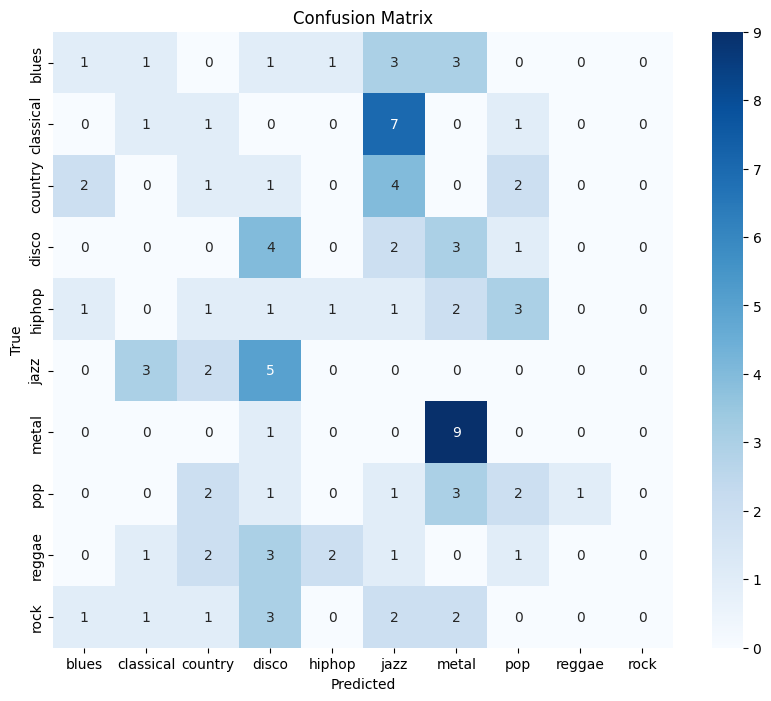

       Genre  TP  TN  FP  FN
0      blues   1  86   4   9
1  classical   1  84   6   9
2    country   1  81   9   9
3      disco   4  74  16   6
4     hiphop   1  87   3   9
5       jazz   0  69  21  10
6      metal   9  77  13   1
7        pop   2  82   8   8
8     reggae   0  89   1  10
9       rock   0  90   0  10


In [101]:
# Question 12

cm = confusion_matrix(y_val, y_pred, labels=GENRES)# COMPUTE CONFUSION MATRIX

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GENRES, yticklabels=GENRES, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Visualize the confusion matrix and compute TP, TN, FP, FN for all genres.
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

metrics_df = pd.DataFrame({
    'Genre': GENRES,
    'TP': tp,
    'TN': tn,
    'FP': fp,
    'FN': fn
})

print(metrics_df)


In [102]:
# Question 12

highest_tp_genre = metrics_df.loc[metrics_df['TP'].idxmax(), 'Genre']
print(f"\nGenre with highest True Positives: {highest_tp_genre}")


Genre with highest True Positives: metal


In [103]:
# Question 13

lowest_fn_genre = metrics_df.loc[metrics_df['FN'].idxmin(), 'Genre']
print(f"Genre with lowest False Negatives: {lowest_fn_genre}")

Genre with lowest False Negatives: metal
